# Select data to use for analysis

Based on the QC reports generated by notebook 03, we've decided to restrict analysis to:

- A subset of kages that passed QC
- A given good week (7-day-period) for each kage
- The most reliable keypoint ("bodycenter")

This notebook selects the appropriate sub-set of data and combines
it into a single xarray Dataset for further analysis.

It also extracts a background frame for each day of the selected week for each kage (for visualization purposes).

In [43]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from matplotlib import pyplot as plt
from tqdm import tqdm

from smart_kages_movement.io import load_background_frame

## Configuration
Defines plotting styles.

In [2]:
# Configure seaborn for prettier plots
sns.set_context("notebook")
sns.set_style("ticks")

Configure xarray display options for better readability.

In [3]:
# Do not expand attributed by default when printing xarray objects
xr.set_options(display_expand_attrs=False)
# Also hide the data repr by default
xr.set_options(display_expand_data=False);

Define paths to the `movement_analysis` directory and the `QC.tsv` file.

In [4]:
project_dir = Path("/mnt/Data/Smart-Kages/2024-04-Apr-May-Downs")
analysis_dir = project_dir / "movement_analysis"
assert analysis_dir.exists(), f"Path does not exist: {analysis_dir}"

qc_file = analysis_dir / "QC.tsv"
assert qc_file.exists(), f"Path does not exist: {qc_file}"

## Load QC results

Let's load the QC results table and parse the dates appropriately.

In [5]:
# Columns containing dates
date_columns = [
    "kage_start_date",
    "good_dates_start",
    "good_dates_end",
    "analysis_start_date",
    "analysis_end_date",
]

# Load QC results
qc_df = pd.read_csv(
    qc_file,
    sep="\t",
    index_col=0,
    parse_dates=date_columns,
)
# Convert "keep" to boolean
qc_df["keep"] = qc_df["keep"].str.lower() == "yes"

# Add column pointing to the netCDF file for each kage
qc_df["data_file"] = qc_df.index.to_series().apply(
    lambda id: (analysis_dir / f"kage{id}" / f"kage{id}.nc").as_posix()
)

qc_df.head()

,kage_start_date,keep,keypoint,good_dates_start,good_dates_end,analysis_start_date,analysis_end_date,best_days_by_loukia,comments,data_file
kage,,,,,,,,,,
1,2024-04-02,True,bodycenter,2024-04-09,2024-05-06,2024-04-13,2024-04-20,"13-19/4, 21-28/4, 30/4-07/05",Cage looks slightly warped - can't see the cor...,/mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/mo...
2,2024-04-02,True,bodycenter,2024-04-13,2024-04-29,2024-04-19,2024-04-26,19-29/04 (but 13/4 is not terrible - talk to N...,video quality quite bad,/mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/mo...
3,2024-04-02,True,bodycenter,2024-04-15,2024-05-06,2024-04-19,2024-04-26,13-25/04,Have a look at the number of frames,/mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/mo...
4,2024-04-02,True,bodycenter,2024-04-19,2024-05-07,2024-04-19,2024-04-26,"19-26/04, 27/04-06/05",NaN,/mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/mo...
5,2024-04-02,True,bodycenter,2024-04-13,2024-05-06,2024-04-29,2024-05-06,21/4-25/4 and 29/04-06/05,have some missimg frames 26-28/04,/mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/mo...


Let's select only the kages that passed QC.

In [6]:
keep_df = qc_df[qc_df["keep"]].copy()
print(f"{len(keep_df)} out of {len(qc_df)} kages are kept for analysis.")
keep_df

26 out of 33 kages are kept for analysis.


,kage_start_date,keep,keypoint,good_dates_start,good_dates_end,analysis_start_date,analysis_end_date,best_days_by_loukia,comments,data_file
kage,,,,,,,,,,
1,2024-04-02,True,bodycenter,2024-04-09,2024-05-06,2024-04-13,2024-04-20,"13-19/4, 21-28/4, 30/4-07/05",Cage looks slightly warped - can't see the cor...,/mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/mo...
2,2024-04-02,True,bodycenter,2024-04-13,2024-04-29,2024-04-19,2024-04-26,19-29/04 (but 13/4 is not terrible - talk to N...,video quality quite bad,/mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/mo...
3,2024-04-02,True,bodycenter,2024-04-15,2024-05-06,2024-04-19,2024-04-26,13-25/04,Have a look at the number of frames,/mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/mo...
4,2024-04-02,True,bodycenter,2024-04-19,2024-05-07,2024-04-19,2024-04-26,"19-26/04, 27/04-06/05",NaN,/mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/mo...
5,2024-04-02,True,bodycenter,2024-04-13,2024-05-06,2024-04-29,2024-05-06,21/4-25/4 and 29/04-06/05,have some missimg frames 26-28/04,/mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/mo...
6,2024-04-02,True,bodycenter,2024-04-13,2024-05-06,2024-04-13,2024-04-20,13/4-25/04 and 28/04-06/05,NaN,/mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/mo...
7,2024-04-02,True,bodycenter,2024-04-13,2024-05-06,2024-04-19,2024-04-26,13/4-25/04 and 27/04-06/05,NaN,/mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/mo...
8,2024-04-02,True,bodycenter,2024-04-13,2024-04-25,2024-04-13,2024-04-20,13/4-20/04,has a lot of missing frames thoughout,/mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/mo...
9,2024-04-02,True,bodycenter,2024-04-13,2024-05-06,2024-04-13,2024-04-20,13/4-18/04 (but all quite good),some missing frames on the 26th of april,/mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/mo...


## Load, select and align data

We **load the cleaned data** (generated in notebook 03) for the **selected kages, week, and keypoint**.

Then we **align each kage's selected week onto a shared 0.5 s timeline**, as follows.

For every selected kage week, we first shift the timestamps so day 1 always starts at `1970‑01‑01`, ensuring all subjects cover the same date range.

To account for mismatched timestamps because of differences in recording start times and dropped frames we snap to the nearest 500 ms tick, by:

1. Rounding each timestamp to the nearest 500 ms tick
2. Keeping only samples that fall within ±250 ms of their rounded target
3. Dropping duplicates so a measurement is never reused
4. Finally reindexing onto the full 7‑day grid.

The result is a set of datasets with identical coordinates, preserving only real observations and leaving unmatched slots as missing values.

In [7]:
reference_date = pd.to_datetime("1970-01-01")
dt = pd.Timedelta("500ms")
tol = dt / 2
common_time_index = pd.date_range(
    start=reference_date,
    end=reference_date + pd.Timedelta(days=7),
    freq=dt,
)

In [8]:
aligned_datasets = {}  # dict to hold selected, cleaned and aligned data

for kage_id, row in tqdm(keep_df.iterrows(), total=len(keep_df)):
    kage_name = "kage" + str(kage_id)
    week_start = pd.to_datetime(row["analysis_start_date"])
    week_end = pd.to_datetime(row["analysis_end_date"])
    keypoint = row["keypoint"]

    # Assert that the week is 7 days long
    n_days = (week_end - week_start).days
    assert n_days == 7, f"Expected 7 days, got {n_days} days instead."

    # Prep the new dataset for this kage
    ds = xr.Dataset()

    # Load the dataset from the netCDF file and
    # select the specified week, individual, and keypoint.
    loaded_ds = xr.open_dataset(row["data_file"]).sel(
        time=slice(week_start, week_end),
        individuals="individual_0",
        keypoints=keypoint,
        drop=False,
    )
    # Copy over the selected clean position, confidence data and attributes
    ds["position"] = loaded_ds["position_clean"]
    ds["confidence"] = loaded_ds["confidence"]
    ds = ds.assign_attrs(loaded_ds.attrs)

    print(
        f"Loaded clean data for {kage_name} {keypoint}, "
        f"from {week_start.date()} to {week_end.date()}."
    )

    # Shift time so that day 1 starts at reference_date
    shifted = ds.assign_coords(
        time=ds.time
        - ds.time[0].values.astype("datetime64[D]")
        + np.datetime64(reference_date)
    )

    # Snap to nearest 500 ms grid point within tolerance
    rounded_time = shifted.indexes["time"].round(dt)
    mask = np.abs(shifted.indexes["time"] - rounded_time) <= tol
    snapped = (
        shifted.isel(time=mask)
        .assign_coords(time=rounded_time[mask])
        .drop_duplicates(dim="time")
        .reindex(time=common_time_index)  # no method, only matches survive
    )

    # Recompute secondary time coord (seconds_elapsed) since reference start
    seconds_since_reference = (
        snapped.time.data - np.datetime64(reference_date)
    ) / pd.Timedelta("1s")
    snapped = snapped.assign_coords(
        seconds_elapsed=("time", seconds_since_reference)
    )

    # Store in the dictionary
    aligned_datasets[kage_name] = snapped

    print(
        "\tAligned to common timeline: from ",
        f"{common_time_index[0].date()} to {common_time_index[-1].date()}.",
    )

  0%|          | 0/26 [00:00<?, ?it/s]

Loaded clean data for kage1 bodycenter, from 2024-04-13 to 2024-04-20.


  4%|▍         | 1/26 [00:35<14:38, 35.12s/it]

	Aligned to common timeline: from  1970-01-01 to 1970-01-08.
Loaded clean data for kage2 bodycenter, from 2024-04-19 to 2024-04-26.


  8%|▊         | 2/26 [01:09<13:56, 34.85s/it]

	Aligned to common timeline: from  1970-01-01 to 1970-01-08.
Loaded clean data for kage3 bodycenter, from 2024-04-19 to 2024-04-26.


 12%|█▏        | 3/26 [01:10<07:25, 19.36s/it]

	Aligned to common timeline: from  1970-01-01 to 1970-01-08.
Loaded clean data for kage4 bodycenter, from 2024-04-19 to 2024-04-26.


 15%|█▌        | 4/26 [01:46<09:24, 25.66s/it]

	Aligned to common timeline: from  1970-01-01 to 1970-01-08.
Loaded clean data for kage5 bodycenter, from 2024-04-29 to 2024-05-06.


 19%|█▉        | 5/26 [02:21<10:12, 29.17s/it]

	Aligned to common timeline: from  1970-01-01 to 1970-01-08.
Loaded clean data for kage6 bodycenter, from 2024-04-13 to 2024-04-20.


 23%|██▎       | 6/26 [02:56<10:25, 31.29s/it]

	Aligned to common timeline: from  1970-01-01 to 1970-01-08.
Loaded clean data for kage7 bodycenter, from 2024-04-19 to 2024-04-26.


 27%|██▋       | 7/26 [03:31<10:17, 32.49s/it]

	Aligned to common timeline: from  1970-01-01 to 1970-01-08.
Loaded clean data for kage8 bodycenter, from 2024-04-13 to 2024-04-20.


 31%|███       | 8/26 [04:06<09:55, 33.09s/it]

	Aligned to common timeline: from  1970-01-01 to 1970-01-08.
Loaded clean data for kage9 bodycenter, from 2024-04-13 to 2024-04-20.


 35%|███▍      | 9/26 [04:41<09:32, 33.67s/it]

	Aligned to common timeline: from  1970-01-01 to 1970-01-08.
Loaded clean data for kage11 bodycenter, from 2024-04-13 to 2024-04-20.


 38%|███▊      | 10/26 [05:16<09:05, 34.11s/it]

	Aligned to common timeline: from  1970-01-01 to 1970-01-08.
Loaded clean data for kage12 bodycenter, from 2024-05-01 to 2024-05-08.


 42%|████▏     | 11/26 [05:48<08:23, 33.56s/it]

	Aligned to common timeline: from  1970-01-01 to 1970-01-08.
Loaded clean data for kage13 bodycenter, from 2024-04-26 to 2024-05-03.


 46%|████▌     | 12/26 [06:23<07:55, 33.94s/it]

	Aligned to common timeline: from  1970-01-01 to 1970-01-08.
Loaded clean data for kage14 bodycenter, from 2024-04-29 to 2024-05-06.


 50%|█████     | 13/26 [06:58<07:26, 34.31s/it]

	Aligned to common timeline: from  1970-01-01 to 1970-01-08.
Loaded clean data for kage16 bodycenter, from 2024-04-13 to 2024-04-20.


 54%|█████▍    | 14/26 [07:33<06:55, 34.60s/it]

	Aligned to common timeline: from  1970-01-01 to 1970-01-08.
Loaded clean data for kage18 bodycenter, from 2024-04-14 to 2024-04-21.


 58%|█████▊    | 15/26 [08:07<06:19, 34.47s/it]

	Aligned to common timeline: from  1970-01-01 to 1970-01-08.
Loaded clean data for kage19 bodycenter, from 2024-04-28 to 2024-05-05.


 62%|██████▏   | 16/26 [08:42<05:46, 34.64s/it]

	Aligned to common timeline: from  1970-01-01 to 1970-01-08.
Loaded clean data for kage20 bodycenter, from 2024-04-21 to 2024-04-28.


 65%|██████▌   | 17/26 [09:18<05:13, 34.84s/it]

	Aligned to common timeline: from  1970-01-01 to 1970-01-08.
Loaded clean data for kage22 bodycenter, from 2024-04-19 to 2024-04-26.


 69%|██████▉   | 18/26 [09:53<04:40, 35.03s/it]

	Aligned to common timeline: from  1970-01-01 to 1970-01-08.
Loaded clean data for kage25 bodycenter, from 2024-04-20 to 2024-04-27.


 73%|███████▎  | 19/26 [10:28<04:05, 35.07s/it]

	Aligned to common timeline: from  1970-01-01 to 1970-01-08.
Loaded clean data for kage26 bodycenter, from 2024-04-19 to 2024-04-26.


 77%|███████▋  | 20/26 [11:04<03:30, 35.08s/it]

	Aligned to common timeline: from  1970-01-01 to 1970-01-08.
Loaded clean data for kage27 bodycenter, from 2024-04-24 to 2024-05-01.


 81%|████████  | 21/26 [11:39<02:55, 35.05s/it]

	Aligned to common timeline: from  1970-01-01 to 1970-01-08.
Loaded clean data for kage29 bodycenter, from 2024-04-20 to 2024-04-27.


 85%|████████▍ | 22/26 [12:14<02:20, 35.10s/it]

	Aligned to common timeline: from  1970-01-01 to 1970-01-08.
Loaded clean data for kage30 bodycenter, from 2024-04-28 to 2024-05-05.


 88%|████████▊ | 23/26 [12:49<01:45, 35.04s/it]

	Aligned to common timeline: from  1970-01-01 to 1970-01-08.
Loaded clean data for kage31 bodycenter, from 2024-04-18 to 2024-04-25.


 92%|█████████▏| 24/26 [13:24<01:10, 35.10s/it]

	Aligned to common timeline: from  1970-01-01 to 1970-01-08.
Loaded clean data for kage32 bodycenter, from 2024-05-01 to 2024-05-08.


 96%|█████████▌| 25/26 [13:59<00:35, 35.15s/it]

	Aligned to common timeline: from  1970-01-01 to 1970-01-08.
Loaded clean data for kage33 bodycenter, from 2024-04-25 to 2024-05-02.


100%|██████████| 26/26 [14:34<00:00, 33.63s/it]

	Aligned to common timeline: from  1970-01-01 to 1970-01-08.


## Combine aligned data into a single xarray Dataset

The combined dataset has dimensions `(time, space, keypoints, individuals)`, where:
- `time` is the common 0.5 s timeline over the chosen week
- `space` holds the x and y coordinates (size = 2)
- `keypoints` corresponds to the `bodycenter` keypoint (size = 1)
- `individuals` corresponds to the kage names

This is convenient for further analysis, so we will save this to a separate file later on.

In [9]:
# Concatenate all datasets along a new "individuals" dimension
combined_dataset = xr.concat(
    aligned_datasets.values(),
    dim=pd.Index(aligned_datasets.keys(), name="individuals"),
    join="exact",
    coords="minimal",
)
# Expand the singleton keypoints dimension to have size 1
combined_dataset = combined_dataset.expand_dims("keypoints")
# Reorder dimensions to (time, space, keypoints, individuals)
combined_dataset = combined_dataset.transpose(
    "time", "space", "keypoints", "individuals"
)

combined_dataset

<xarray.Dataset> Size: 774MB
Dimensions:          (keypoints: 1, individuals: 26, time: 1209601, space: 2)
Coordinates:
  * keypoints        (keypoints) <U10 40B 'bodycenter'
  * individuals      (individuals) object 208B 'kage1' 'kage2' ... 'kage33'
  * time             (time) datetime64[ns] 10MB 1970-01-01 ... 1970-01-08
  * space            (space) <U1 8B 'x' 'y'
    seconds_elapsed  (time) float64 10MB 0.0 0.5 1.0 ... 6.048e+05 6.048e+05
Data variables:
    position         (time, space, keypoints, individuals) float64 503MB nan ...
    confidence       (time, keypoints, individuals) float64 252MB nan ... nan
Attributes: (7)

In [10]:
# Show memory usage
combined_dataset_mb = combined_dataset.nbytes / (1024**2)  # in MB
print(f"Combined dataset uses {combined_dataset_mb:.2f} MB of memory.")

Combined dataset uses 738.28 MB of memory.


## Save the selected and aligned data

We will save data in two different formats:
- As a combined NetCDF file for easy loading in future xarray-based analyses. The time coordinates will be in datetime format.
- As individual NetCDF files per kage for compatibility with `movement`'s GUI. In this version we will set the time coordinates to seconds elapsed.

In [11]:
combined_dataset.to_netcdf(analysis_dir / "bodycenter_best_week.nc")

In [32]:
kages = combined_dataset["individuals"].values

for kage in tqdm(kages, total=len(kages)):
    ds_kage = (
        combined_dataset.sel(individuals=kage, drop=False)
        .set_index(time="seconds_elapsed")
        .expand_dims("individuals")
        .transpose("time", "space", "keypoints", "individuals")
    )
    ds_kage.to_netcdf(analysis_dir / kage / f"{kage}_bodycenter_best_week.nc")

100%|██████████| 26/26 [00:02<00:00,  9.28it/s]


## Extract a background frame for each day

We will extract a background frame for each day of the selected week for each kage.

The background frame is computed as the average of the first 100 frames from the video corresponding to 05:00 - 06:00 AM.

It will be used later on for visualization purposes.

In [34]:
keep_df.head()

,kage_start_date,keep,keypoint,good_dates_start,good_dates_end,analysis_start_date,analysis_end_date,best_days_by_loukia,comments,data_file
kage,,,,,,,,,,
1,2024-04-02,True,bodycenter,2024-04-09,2024-05-06,2024-04-13,2024-04-20,"13-19/4, 21-28/4, 30/4-07/05",Cage looks slightly warped - can't see the cor...,/mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/mo...
2,2024-04-02,True,bodycenter,2024-04-13,2024-04-29,2024-04-19,2024-04-26,19-29/04 (but 13/4 is not terrible - talk to N...,video quality quite bad,/mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/mo...
3,2024-04-02,True,bodycenter,2024-04-15,2024-05-06,2024-04-19,2024-04-26,13-25/04,Have a look at the number of frames,/mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/mo...
4,2024-04-02,True,bodycenter,2024-04-19,2024-05-07,2024-04-19,2024-04-26,"19-26/04, 27/04-06/05",NaN,/mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/mo...
5,2024-04-02,True,bodycenter,2024-04-13,2024-05-06,2024-04-29,2024-05-06,21/4-25/4 and 29/04-06/05,have some missimg frames 26-28/04,/mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/mo...


  4%|▍         | 1/26 [00:01<00:41,  1.66s/it]

Saved daily background frames for kage1 from 2024-04-13 to 2024-04-20.


  8%|▊         | 2/26 [00:03<00:39,  1.66s/it]

Saved daily background frames for kage2 from 2024-04-19 to 2024-04-26.


 12%|█▏        | 3/26 [00:04<00:37,  1.65s/it]

Saved daily background frames for kage3 from 2024-04-19 to 2024-04-26.


 15%|█▌        | 4/26 [00:06<00:36,  1.65s/it]

Saved daily background frames for kage4 from 2024-04-19 to 2024-04-26.


 19%|█▉        | 5/26 [00:08<00:34,  1.64s/it]

Saved daily background frames for kage5 from 2024-04-29 to 2024-05-06.


 23%|██▎       | 6/26 [00:09<00:32,  1.65s/it]

Saved daily background frames for kage6 from 2024-04-13 to 2024-04-20.


 27%|██▋       | 7/26 [00:11<00:31,  1.65s/it]

Saved daily background frames for kage7 from 2024-04-19 to 2024-04-26.


 31%|███       | 8/26 [00:13<00:29,  1.63s/it]

Saved daily background frames for kage8 from 2024-04-13 to 2024-04-20.


 35%|███▍      | 9/26 [00:14<00:27,  1.64s/it]

Saved daily background frames for kage9 from 2024-04-13 to 2024-04-20.


 38%|███▊      | 10/26 [00:16<00:26,  1.65s/it]

Saved daily background frames for kage11 from 2024-04-13 to 2024-04-20.


 42%|████▏     | 11/26 [00:18<00:24,  1.65s/it]

Saved daily background frames for kage12 from 2024-05-01 to 2024-05-08.


 46%|████▌     | 12/26 [00:19<00:22,  1.64s/it]

Saved daily background frames for kage13 from 2024-04-26 to 2024-05-03.


 50%|█████     | 13/26 [00:21<00:21,  1.65s/it]

Saved daily background frames for kage14 from 2024-04-29 to 2024-05-06.


 54%|█████▍    | 14/26 [00:23<00:19,  1.65s/it]

Saved daily background frames for kage16 from 2024-04-13 to 2024-04-20.


 58%|█████▊    | 15/26 [00:24<00:18,  1.65s/it]

Saved daily background frames for kage18 from 2024-04-14 to 2024-04-21.


 62%|██████▏   | 16/26 [00:26<00:16,  1.64s/it]

Saved daily background frames for kage19 from 2024-04-28 to 2024-05-05.


 65%|██████▌   | 17/26 [00:27<00:14,  1.65s/it]

Saved daily background frames for kage20 from 2024-04-21 to 2024-04-28.


 69%|██████▉   | 18/26 [00:29<00:13,  1.65s/it]

Saved daily background frames for kage22 from 2024-04-19 to 2024-04-26.


 73%|███████▎  | 19/26 [00:31<00:11,  1.65s/it]

Saved daily background frames for kage25 from 2024-04-20 to 2024-04-27.


 77%|███████▋  | 20/26 [00:32<00:09,  1.65s/it]

Saved daily background frames for kage26 from 2024-04-19 to 2024-04-26.


 81%|████████  | 21/26 [00:34<00:08,  1.65s/it]

Saved daily background frames for kage27 from 2024-04-24 to 2024-05-01.


 85%|████████▍ | 22/26 [00:36<00:06,  1.66s/it]

Saved daily background frames for kage29 from 2024-04-20 to 2024-04-27.


 88%|████████▊ | 23/26 [00:37<00:04,  1.67s/it]

Saved daily background frames for kage30 from 2024-04-28 to 2024-05-05.


 92%|█████████▏| 24/26 [00:39<00:03,  1.65s/it]

Saved daily background frames for kage31 from 2024-04-18 to 2024-04-25.


 96%|█████████▌| 25/26 [00:41<00:01,  1.67s/it]

Saved daily background frames for kage32 from 2024-05-01 to 2024-05-08.


100%|██████████| 26/26 [00:42<00:00,  1.65s/it]

Saved daily background frames for kage33 from 2024-04-25 to 2024-05-02.


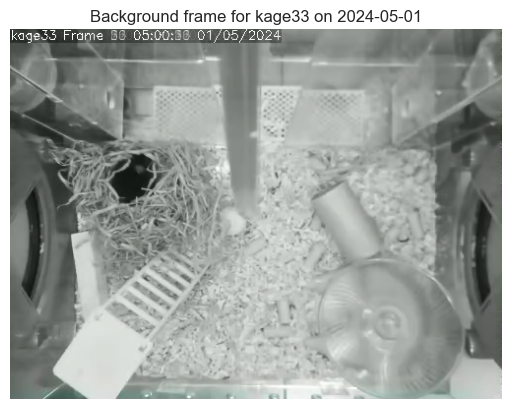

In [48]:
for kage, row in tqdm(keep_df.iterrows(), total=len(keep_df)):
    kage_name = "kage" + str(kage)
    week_start = pd.to_datetime(row["analysis_start_date"])
    week_end = pd.to_datetime(row["analysis_end_date"])

    # Iterate over each day in the selected week
    current_day = week_start

    for _ in range(7):
        year = current_day.year
        month = f"{current_day.month:02d}"
        day = f"{current_day.day:02d}"
        video_dir = (
            project_dir
            / "DB"
            / kage_name
            / "videos"
            / str(year)
            / str(month)
            / str(day)
        )
        assert video_dir.exists(), (
            f"Couldn't find video directory: {video_dir}."
        )

        # Find video file corresponding 05:00 - 06:00 AM
        video_prefix = f"{kage_name}_{year}{month}{day}_05"
        video_files = list(video_dir.glob(f"{video_prefix}*.mp4"))
        n_videos = len(video_files)
        if n_videos != 1:
            msg = f"Expected 1 video file, found {n_videos}: {video_files}"
            raise ValueError(msg)
        video_path = video_files[0]

        # Load background frame from the video
        img = load_background_frame(video_path=video_path)
        # Save the background frame as a PNG file
        frame_filename = f"{kage_name}_background_{year}-{month}-{day}.png"
        frame_path = analysis_dir / kage_name / frame_filename
        plt.imsave(frame_path, img)

        # Move to the next day
        current_day += pd.Timedelta(days=1)

    print(
        f"Saved daily background frames for {kage_name} "
        f"from {week_start.date()} to {week_end.date()}."
    )


# Show the last image as a sample
if kage == keep_df.index[-1]:
    plt.imshow(img)
    plt.title(f"Background frame for {kage_name} on {year}-{month}-{day}")
    plt.axis("off")
    plt.show()